# Analysis of Epinions social network

Import the necessary packages

In [6]:
import networkx as nx
import pandas as pd
import pylab
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from community import community_louvain
import numpy as np
import community
import random

Creating the graph

In [8]:
graph = nx.DiGraph()
epi_csv = pd.read_csv('soc-sign-epinions.csv')
epi_csv.columns = ['From','To','Weight']
# We check if the file has loaded
epi_csv.head()

# Adding the edges.

for index,row in epi_csv.iterrows():
    graph.add_edges_from([(row[0],row[1])],weight = row[2])

Creating the DataFrame containing degrees

In [9]:
# Number of nodes
print(graph.number_of_nodes())

# Number of edges
print(graph.number_of_edges())

# Positive and negative edges 

Stats = pd.DataFrame(graph.out_degree(),columns=['From','Outdegree']).sort_values('From')
Stats_2 =  pd.DataFrame(graph.in_degree(),columns=['To','Indegree']).sort_values('To')
b= epi_csv.groupby('From',as_index=False)[['Weight']].sum().sort_values('From')
c= epi_csv.groupby('To',as_index=False)[['Weight']].sum().sort_values('To')
Stats = Stats.merge(b,on='From',how='left')
Stats_2 = Stats_2.merge(c,on='To',how='left')
Stats['Pos_out'] = (  Stats['Outdegree'] + Stats['Weight']  )/2
Stats['Neg_out'] = (  Stats['Outdegree'] - Stats['Weight']  )/2
Stats_2['Pos_in']= (Stats_2['Indegree']  + Stats_2['Weight'])/2
Stats_2['Neg_in']= (Stats_2['Indegree']  - Stats_2['Weight'])/2
Stats = pd.merge(Stats,Stats_2,left_on='From', right_on='To').drop('To', axis=1)
Stats = Stats.drop(['Weight_x','Weight_y'],axis=1)
Stats.fillna(0,inplace=True)
Stats.head()

131828
841372


,From,Outdegree,Pos_out,Neg_out,Indegree,Pos_in,Neg_in
0,0,1,0.0,1.0,0,0.0,0.0
1,1,1,0.0,1.0,2,1.0,1.0
2,2,1,1.0,0.0,1,1.0,0.0
3,3,0,0.0,0.0,4,4.0,0.0
4,4,14,9.0,5.0,1,1.0,0.0


In [10]:
Stats.describe()
print(Stats.max(axis=0))

From         131827.0
Outdegree      2070.0
Pos_out        2070.0
Neg_out        1562.0
Indegree       3478.0
Pos_in         3338.0
Neg_in          540.0
dtype: float64


Basic stats

In [11]:
print(graph.number_of_edges())
print(graph.number_of_nodes())
print(nx.average_clustering(graph))
print(nx.transitivity(graph))
print(nx.density(graph))

841372
131828
0.09561744905322256
0.07428166527700729
4.841456374018419e-05


Log-Log plots of degrees:
    Out degree and indegree relationship, relationship between positive and negative weighted outgoing edges in the 
    network and relationship between positive and negative ingoing edges.

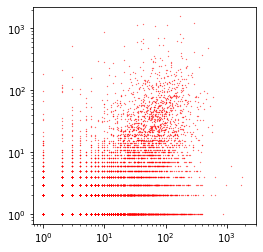

In [12]:
plt.figure(figsize=(4,4))
plt.plot(Stats['Pos_out'],Stats['Neg_out'],'ro',markersize=0.25)
plt.xscale('log')
plt.yscale('log')

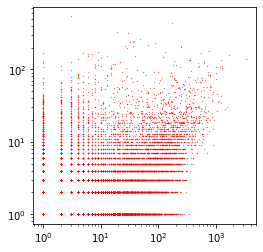

In [13]:
plt.figure(figsize=(4,4))
plt.plot(Stats['Pos_in'],Stats['Neg_in'],'ro',markersize=0.25)
plt.xscale('log')
plt.yscale('log')

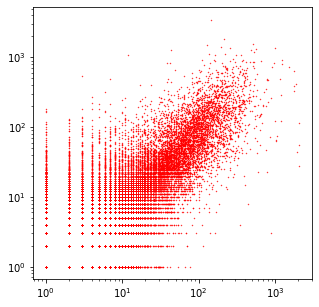

In [14]:
plt.figure(figsize=(5,5))
plt.plot(Stats['Outdegree'],Stats['Indegree'],'ro',markersize=0.4)
plt.xscale('log')
plt.yscale('log')

Plotting the assortativity coefficients of the nodes.

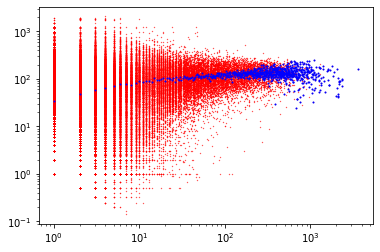

In [15]:
Deg_cor = nx.average_neighbor_degree(graph,target='out')
dict_list = []
for key, value in Deg_cor.items():
    temp = [key,value]
    temp[0] = graph.degree(key,'out')
    dict_list.append(temp)
dfa1 = pd.DataFrame(dict_list,columns =['Outdegree','Average neighbors outdegree'])
dfa2 = dfa1.groupby('Outdegree',as_index=False)['Average neighbors outdegree'].mean()
plt.plot(dfa1['Outdegree'],dfa1['Average neighbors outdegree'],'ro',markersize=0.3)
plt.plot(dfa2['Outdegree'],dfa2['Average neighbors outdegree'],'bo',markersize=1)
plt.xscale('log')
plt.yscale('log')

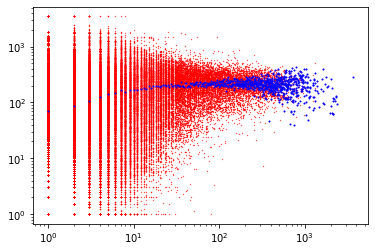

In [16]:
Deg_cor = nx.average_neighbor_degree(graph,target='in')
dict_list = []
for key, value in Deg_cor.items():
    temp = [key,value]
    temp[0] = graph.degree(key,'in')
    dict_list.append(temp)
dfa1 = pd.DataFrame(dict_list,columns =['Indegree','Average neighbors indegree'])
dfa2 = dfa1.groupby('Indegree',as_index=False)['Average neighbors indegree'].mean()
plt.plot(dfa1['Indegree'],dfa1['Average neighbors indegree'],'ro',markersize=0.3)
plt.plot(dfa2['Indegree'],dfa2['Average neighbors indegree'],'bo',markersize=1)

plt.xscale('log')
plt.yscale('log')

Checking assortativity

In [18]:
print(nx.degree_assortativity_coefficient(graph,'in','in'))
print(nx.degree_assortativity_coefficient(graph,'out','out'))

0.005121469550551805
-0.030516704380786353


Checking the power law

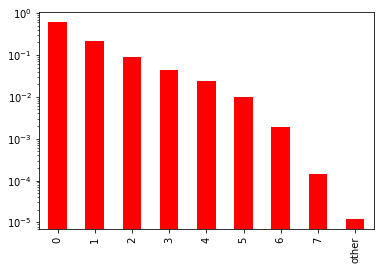

In [19]:
import math
pos = Stats['Indegree'][Stats['Indegree'] != 0]
pos = pos.transform(lambda x: math.floor(math.log(x)) )

prob = pos.value_counts(normalize=True)
threshold = 0.0001
mask = prob > threshold
tail_prob = prob.loc[~mask].sum()
prob = prob.loc[mask]
prob['other'] = tail_prob
prob.plot(kind='bar',log=True,color='r')

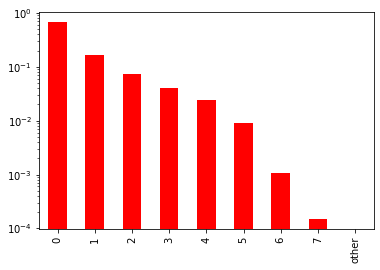

In [20]:
import math
pos = Stats['Outdegree'][Stats['Outdegree'] != 0]
pos = pos.transform(lambda x: math.floor(math.log(x)) )

prob = pos.value_counts(normalize=True)
threshold = 0.0001
mask = prob > threshold
tail_prob = prob.loc[~mask].sum()
prob = prob.loc[mask]
prob['other'] = tail_prob
prob.plot(kind='bar',log=True,color='r')

Assortativity coefficients

In [21]:
nx.degree_assortativity_coefficient(graph,'in')
nx.degree_assortativity_coefficient(graph,'out')
nx.degree_assortativity_coefficient(graph)

-0.06430169476171489

Size of components for bowtie structure

In [22]:
SCC = max(nx.strongly_connected_components(graph), key=len)
print('Size of maximal strongly connected component is ' + str(len(SCC)))
WCC = max(nx.weakly_connected_components(graph), key=len)
print('Size of maximal weakly connected component is ' + str(len(WCC)))

Size of maximal strongly connected component is 41441
Size of maximal weakly connected component is 119130


Community detection in graph

In [23]:
SCC = max(nx.strongly_connected_components(graph), key=len)
scc_com = graph.subgraph(SCC).copy()
scc2 = nx.Graph(scc_com)

# Removing the weights.

for u,v,d in scc2.edges(data=True):
    d['weight']=1

communities =community_louvain.best_partition(scc2,random_state=5)

In [24]:
print(set(communities.values()))

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221,

Getting the sizes of the communities

In [26]:
ind_graph = community.induced_graph(communities, scc2)

inv_map = dict()
for key, value in communities.items():
    inv_map.setdefault(value, list()).append(key)
    
# Removing the small communities

inv_map2 = {key:val for key, val in inv_map.items() if len(val) >= 100}
sizes = np.array([len(inv_map2[k]) for k in list(inv_map2.keys())])

# Removing edges from the graph:

inv_keys = [key for key in inv_map2]
ind_nodes = list(ind_graph.nodes())
for node in ind_nodes:
    if node not in inv_keys:
        ind_graph.remove_node(node)
print(sizes)

[10032 10540   453 11587  4309   221   143   945   311   111   124]


Checking the rich club effect

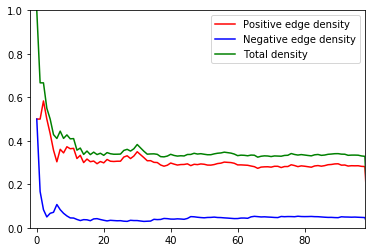

0.6515615431720759

In [27]:
# We want to see the rich club effect in the 100 edges with the highest indegree.
picked = 100
rce1 = Stats[['From','Indegree']].sort_values(by=['Indegree'], ascending=False)[0:picked]
rich = list(rce1.From.values)
rece_graph = graph.subgraph(rich).copy()
# Dropping first value

densities = np.zeros((3,picked))
pos_edges = 0
neg_edges = 0 
for rank, node1 in enumerate(rich[1::]):
    
    for rank2, node2 in enumerate(rich[:rank+1]): 
        if graph.has_edge(node1, node2):
            if graph[node1][node2]['weight'] == 1:
                pos_edges += 1
            else:
                neg_edges += 1
        if graph.has_edge(node2, node1):
            if graph[node2][node1]['weight'] == 1:
                pos_edges += 1
            else:
                neg_edges += 1
            
    densities[0][rank] = pos_edges/(rank+2)/(rank+1)
    densities[1][rank] = neg_edges/(rank+2)/(rank+1)
    densities[2][rank] = (pos_edges + neg_edges)/(rank+2)/(rank+1)
    

plt.plot( [i for i in range(0,picked)],densities[0,],'r-',label='Positive edge density')
plt.plot( [i for i in range(0,picked)],densities[1,],'b-',label='Negative edge density')
plt.plot( [i for i in range(0,picked)],densities[2,],'g-',label='Total density')
plt.legend(loc="upper right")
plt.ylim((0,1))
plt.xlim((-2,picked-2))
plt.show()


# Checking the one sidedness
nx.reciprocity(rece_graph)

Negative rich club

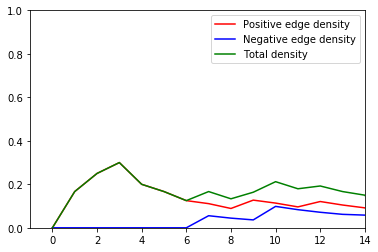

In [28]:
# We want to see the rich club effect in the 100 edges with the highest negative_degree.
picked = 16
rce2 = Stats[['From','Neg_in']].sort_values(by=['Neg_in'], ascending=False)[4:picked+4]
rich = list(rce2.From.values)
# Dropping first value

densities = np.zeros((3,picked))
pos_edges = 0
neg_edges = 0 

for rank, node1 in enumerate(rich[1::]):
    
    for rank2, node2 in enumerate(rich[:rank+1]): 
        if graph.has_edge(node1, node2):
            if graph[node1][node2]['weight'] == 1:
                pos_edges += 1
            else:
                neg_edges += 1
        if graph.has_edge(node2, node1):
            if graph[node2][node1]['weight'] == 1:
                pos_edges += 1
            else:
                neg_edges += 1
                
            
    densities[0][rank] = pos_edges/(rank+2)/(rank+1)
    densities[1][rank] = neg_edges/(rank+2)/(rank+1)
    densities[2][rank] = (pos_edges + neg_edges)/(rank+2)/(rank+1)
    

plt.plot( [i for i in range(0,picked)],densities[0,],'r-',label='Positive edge density')
plt.plot( [i for i in range(0,picked)],densities[1,],'b-',label='Negative edge density')
plt.plot( [i for i in range(0,picked)],densities[2,],'g-',label='Total density')
plt.legend(loc="upper right")
plt.ylim((0,1))
plt.xlim((-1,picked-2))
plt.show()